In [2031]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.tsa.api import VAR
from statsmodels.tools.eval_measures import rmse, aic

register_matplotlib_converters()

In [2032]:
def perform_adf_test(series):
    result = adfuller(series)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])

In [2033]:
def smape(y, y_hat):
    """
    Calculates Symmetric Mean Absolute Percentage Error.

    Parameters:
    - y (numpy array): Actual test values.
    - y_hat (numpy array): Predicted values.

    Returns:
    - float: Symmetric mean absolute percentage error.
    """
    y = np.reshape(y, (-1,))
    y_hat = np.reshape(y_hat, (-1,))
    smape = np.mean(2.0 * np.abs(y - y_hat) / (np.abs(y) + np.abs(y_hat)))

    return smape

In [2034]:
def invert_transformation(df_train, df_forecast):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 1st Diff
        df_fc[col] = df_train[col].iloc[-1] + df_fc[col].cumsum()
        
    return df_fc

In [2035]:
df_daily_currencies = pd.read_csv("/kaggle/input/cleaned-unnorm/cleaned_unnorm.csv")
df_daily_currencies = df_daily_currencies.drop(columns = "Unnamed: 0")

df_daily_currencies = df_daily_currencies[df_daily_currencies.columns[1:]]

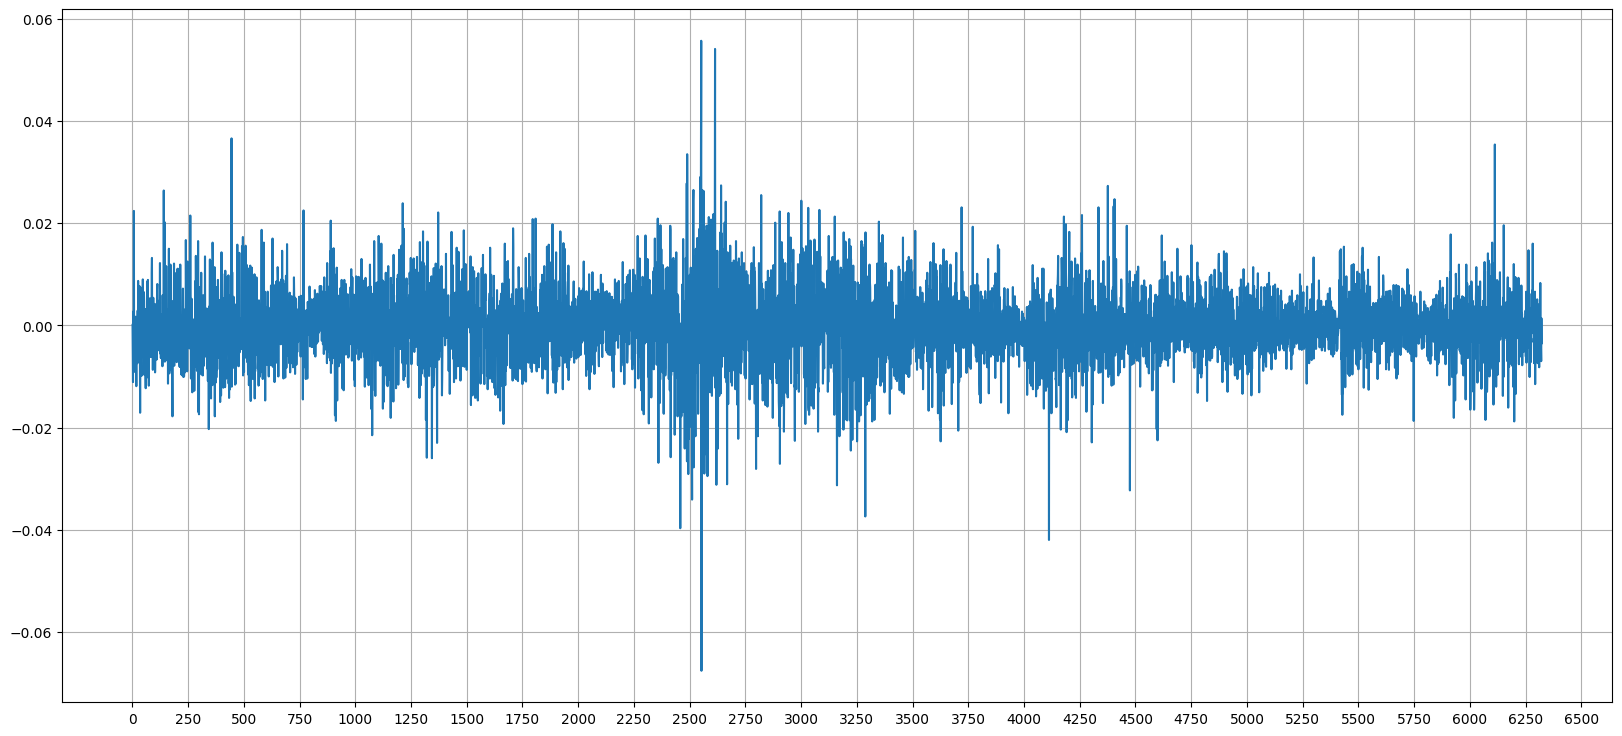

In [2036]:
df_diff = df_daily_currencies.diff().dropna()

df_diff["USD"].plot(figsize=(20, 9))
plt.grid()
plt.xticks(np.arange(0, len(df_daily_currencies)//250 * 250 + 500, 250))
plt.show()

#### Running augmented Dickey-Fuller tests is a more mathematically rigorous way to have conclusive evidence about trends and seasonality in our time-series. 

#### Any p-value above 0.05 (5%) means that there's still information to be extracted by differencing.

In [2037]:
print("Order 1 diff")
perform_adf_test(df_diff["USD"])

Order 1 diff
ADF Statistic: -22.743339
p-value: 0.000000


In [2038]:
horizon = 14

data_end = len(df_daily_currencies) - horizon
data_start = 1

df_train = df_diff.iloc[data_start -1 : data_end - 1]
df_test = df_diff.iloc[data_end - 1: data_end + horizon]

In [2039]:
df_train

,USD,JPY,CZK,DKK,GBP,HUF,PLN,SEK,CHF,NOK,AUD,CAD,HKD,KRW,NZD,SGD,ZAR
1,0.0001,-2.77,-0.190,-0.0006,0.00110,-0.68,-0.0467,-0.0671,-0.0045,-0.0805,-0.0156,-0.0039,0.0009,-25.58,-0.0218,0.0101,-0.1383
2,-0.0047,0.46,-0.067,-0.0043,-0.00460,-0.13,-0.0180,-0.0975,-0.0007,-0.0410,-0.0124,-0.0254,-0.0331,-13.47,-0.0121,0.0044,-0.0668
3,-0.0111,-1.99,0.036,-0.0021,-0.00175,-0.58,0.0100,-0.1250,0.0049,-0.1040,-0.0346,-0.0109,-0.0879,-22.38,-0.0359,-0.0263,0.0976
4,0.0027,0.66,0.052,0.0002,0.00355,0.06,0.0198,-0.0150,-0.0027,-0.0395,-0.0068,0.0041,0.0171,29.57,0.0026,0.0101,-0.0428
5,-0.0090,-3.76,0.235,0.0000,-0.00500,-0.45,-0.0043,-0.0665,-0.0034,-0.0315,-0.0272,-0.0180,-0.0647,-10.03,-0.0300,-0.0179,0.0055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6304,-0.0074,-0.29,-0.065,0.0005,-0.00200,-0.02,0.0027,0.0330,-0.0009,0.0115,0.0003,-0.0091,-0.0549,0.09,0.0006,-0.0037,0.0743
6305,-0.0004,0.36,0.100,0.0004,-0.00260,5.70,0.0493,-0.0015,-0.0022,0.0365,0.0035,0.0042,0.0024,1.30,0.0000,0.0016,0.1932
6306,-0.0010,0.03,-0.078,0.0001,-0.00310,-3.03,-0.0360,-0.0110,0.0019,-0.0175,0.0007,-0.0016,-0.0016,0.41,-0.0023,-0.0007,-0.1142
6307,-0.0016,-0.19,0.018,-0.0002,-0.00250,-0.72,0.0190,0.0386,-0.0050,0.0455,0.0036,-0.0008,-0.0148,-2.83,0.0016,-0.0029,-0.1254


In [2040]:
df_train.iloc[0:]

,USD,JPY,CZK,DKK,GBP,HUF,PLN,SEK,CHF,NOK,AUD,CAD,HKD,KRW,NZD,SGD,ZAR
1,0.0001,-2.77,-0.190,-0.0006,0.00110,-0.68,-0.0467,-0.0671,-0.0045,-0.0805,-0.0156,-0.0039,0.0009,-25.58,-0.0218,0.0101,-0.1383
2,-0.0047,0.46,-0.067,-0.0043,-0.00460,-0.13,-0.0180,-0.0975,-0.0007,-0.0410,-0.0124,-0.0254,-0.0331,-13.47,-0.0121,0.0044,-0.0668
3,-0.0111,-1.99,0.036,-0.0021,-0.00175,-0.58,0.0100,-0.1250,0.0049,-0.1040,-0.0346,-0.0109,-0.0879,-22.38,-0.0359,-0.0263,0.0976
4,0.0027,0.66,0.052,0.0002,0.00355,0.06,0.0198,-0.0150,-0.0027,-0.0395,-0.0068,0.0041,0.0171,29.57,0.0026,0.0101,-0.0428
5,-0.0090,-3.76,0.235,0.0000,-0.00500,-0.45,-0.0043,-0.0665,-0.0034,-0.0315,-0.0272,-0.0180,-0.0647,-10.03,-0.0300,-0.0179,0.0055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6304,-0.0074,-0.29,-0.065,0.0005,-0.00200,-0.02,0.0027,0.0330,-0.0009,0.0115,0.0003,-0.0091,-0.0549,0.09,0.0006,-0.0037,0.0743
6305,-0.0004,0.36,0.100,0.0004,-0.00260,5.70,0.0493,-0.0015,-0.0022,0.0365,0.0035,0.0042,0.0024,1.30,0.0000,0.0016,0.1932
6306,-0.0010,0.03,-0.078,0.0001,-0.00310,-3.03,-0.0360,-0.0110,0.0019,-0.0175,0.0007,-0.0016,-0.0016,0.41,-0.0023,-0.0007,-0.1142
6307,-0.0016,-0.19,0.018,-0.0002,-0.00250,-0.72,0.0190,0.0386,-0.0050,0.0455,0.0036,-0.0008,-0.0148,-2.83,0.0016,-0.0029,-0.1254


In [2041]:
model = VAR(df_train.iloc[0:])

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [2042]:
if(False):
    for i in range(1, 20 + 1):
        result = model.fit(i)
        print('Lag Order =', i)
        print('AIC : ', result.aic)
        #print('BIC : ', result.bic)
       # print('FPE : ', result.fpe)
       # print('HQIC: ', result.hqic, '\n')

# V-AR(p) DAILY

In [2043]:
lag = 4
model_fitted = model.fit(lag)
#model_fitted.summary()

from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

def adjust(val, length= 6): 
    return str(val).ljust(length)

for col, val in zip(df_diff.columns, out):
    print(adjust(col), ':', round(val, 2))

USD    : 2.0
JPY    : 2.0
CZK    : 1.99
DKK    : 2.0
GBP    : 2.0
HUF    : 2.0
PLN    : 2.0
SEK    : 2.0
CHF    : 2.0
NOK    : 2.0
AUD    : 2.0
CAD    : 2.0
HKD    : 2.0
KRW    : 2.01
NZD    : 2.0
SGD    : 2.0
ZAR    : 2.0


In [2044]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input = df_train.values[-lag_order:]
print(forecast_input)

df_train[- lag_order:]

4
[[-4.000e-04  3.600e-01  1.000e-01  4.000e-04 -2.600e-03  5.700e+00
   4.930e-02 -1.500e-03 -2.200e-03  3.650e-02  3.500e-03  4.200e-03
   2.400e-03  1.300e+00  0.000e+00  1.600e-03  1.932e-01]
 [-1.000e-03  3.000e-02 -7.800e-02  1.000e-04 -3.100e-03 -3.030e+00
  -3.600e-02 -1.100e-02  1.900e-03 -1.750e-02  7.000e-04 -1.600e-03
  -1.600e-03  4.100e-01 -2.300e-03 -7.000e-04 -1.142e-01]
 [-1.600e-03 -1.900e-01  1.800e-02 -2.000e-04 -2.500e-03 -7.200e-01
   1.900e-02  3.860e-02 -5.000e-03  4.550e-02  3.600e-03 -8.000e-04
  -1.480e-02 -2.830e+00  1.600e-03 -2.900e-03 -1.254e-01]
 [-3.300e-03 -7.700e-01 -4.100e-02 -4.000e-04  9.800e-04 -1.140e+00
  -2.000e-03  7.170e-02  1.600e-03  8.150e-02  6.800e-03  1.500e-03
  -2.130e-02 -1.240e+00  5.200e-03 -4.200e-03 -2.840e-02]]


,USD,JPY,CZK,DKK,GBP,HUF,PLN,SEK,CHF,NOK,AUD,CAD,HKD,KRW,NZD,SGD,ZAR
6305,-0.0004,0.36,0.100,0.0004,-0.00260,5.70,0.0493,-0.0015,-0.0022,0.0365,0.0035,0.0042,0.0024,1.30,0.0000,0.0016,0.1932
6306,-0.0010,0.03,-0.078,0.0001,-0.00310,-3.03,-0.0360,-0.0110,0.0019,-0.0175,0.0007,-0.0016,-0.0016,0.41,-0.0023,-0.0007,-0.1142
6307,-0.0016,-0.19,0.018,-0.0002,-0.00250,-0.72,0.0190,0.0386,-0.0050,0.0455,0.0036,-0.0008,-0.0148,-2.83,0.0016,-0.0029,-0.1254
6308,-0.0033,-0.77,-0.041,-0.0004,0.00098,-1.14,-0.0020,0.0717,0.0016,0.0815,0.0068,0.0015,-0.0213,-1.24,0.0052,-0.0042,-0.0284


In [2045]:
fc = model_fitted.forecast(y = forecast_input, steps=horizon)
df_forecast = pd.DataFrame(fc, index=df_test.index, columns=df_test.columns)
#df_forecast

In [2046]:
df_daily_currencies[data_end: data_end + horizon]

,USD,JPY,CZK,DKK,GBP,HUF,PLN,SEK,CHF,NOK,AUD,CAD,HKD,KRW,NZD,SGD,ZAR
6309,1.0908,159.15,24.020,7.4524,0.85475,381.73,4.4785,11.9095,0.9588,11.5205,1.6995,1.4723,8.5488,1460.32,1.8407,1.4791,20.6760
6310,1.0887,158.70,24.000,7.4535,0.85288,382.03,4.4643,11.8630,0.9565,11.5195,1.6878,1.4716,8.5328,1454.59,1.8264,1.4754,20.3932
6311,1.0805,157.28,24.132,7.4531,0.85653,383.33,4.4773,11.9061,0.9524,11.5730,1.6840,1.4667,8.4716,1448.26,1.8224,1.4677,20.2097
6312,1.0840,157.96,24.130,7.4539,0.85650,384.23,4.4768,11.9175,0.9562,11.5775,1.6838,1.4686,8.5009,1433.05,1.8266,1.4681,20.2480
6313,1.0808,157.75,24.117,7.4537,0.85643,381.78,4.4690,11.8950,0.9564,11.5180,1.6809,1.4672,8.4770,1430.58,1.8248,1.4641,20.1578
6314,1.0808,158.35,24.138,7.4530,0.85815,382.63,4.4735,11.9000,0.9559,11.5705,1.6839,1.4693,8.4789,1433.73,1.8283,1.4659,20.1598
6315,1.0803,158.93,24.163,7.4529,0.85860,382.25,4.4720,11.8820,0.9558,11.5645,1.6832,1.4722,8.4770,1432.91,1.8307,1.4649,20.0496
6316,1.0886,159.15,24.107,7.4531,0.85920,379.85,4.4728,11.8410,0.9568,11.5460,1.6814,1.4764,8.5427,1442.07,1.8250,1.4723,20.2170
6317,1.0868,158.49,24.072,7.4523,0.85718,380.13,4.4673,11.8430,0.9584,11.5800,1.6785,1.4721,8.5250,1439.56,1.8259,1.4686,20.4199
6318,1.0844,157.47,24.118,7.4528,0.85538,383.73,4.4685,11.8960,0.9574,11.4860,1.6737,1.4656,8.5068,1428.30,1.8164,1.4640,20.2711


In [2047]:
df_daily_results = invert_transformation(df_daily_currencies[data_end + 1: data_end + horizon + 1], df_forecast)        
#df_daily_results

In [2048]:
df_daily_currencies

,USD,JPY,CZK,DKK,GBP,HUF,PLN,SEK,CHF,NOK,AUD,CAD,HKD,KRW,NZD,SGD,ZAR
0,1.1789,133.73,35.107,7.4501,0.71110,251.48,4.0712,9.4696,1.6168,8.8550,1.9100,1.8004,9.1332,1398.59,2.2229,1.9554,6.9358
1,1.1790,130.96,34.917,7.4495,0.71220,250.80,4.0245,9.4025,1.6123,8.7745,1.8944,1.7965,9.1341,1373.01,2.2011,1.9655,6.7975
2,1.1743,131.42,34.850,7.4452,0.70760,250.67,4.0065,9.3050,1.6116,8.7335,1.8820,1.7711,9.1010,1359.54,2.1890,1.9699,6.7307
3,1.1632,129.43,34.886,7.4431,0.70585,250.09,4.0165,9.1800,1.6165,8.6295,1.8474,1.7602,9.0131,1337.16,2.1531,1.9436,6.8283
4,1.1659,130.09,34.938,7.4433,0.70940,250.15,4.0363,9.1650,1.6138,8.5900,1.8406,1.7643,9.0302,1366.73,2.1557,1.9537,6.7855
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6318,1.0844,157.47,24.118,7.4528,0.85538,383.73,4.4685,11.8960,0.9574,11.4860,1.6737,1.4656,8.5068,1428.30,1.8164,1.4640,20.2711
6319,1.0801,158.11,24.108,7.4527,0.85550,383.05,4.4663,11.9010,0.9548,11.5005,1.6708,1.4686,8.4620,1423.17,1.8170,1.4622,20.4602
6320,1.0731,158.20,24.161,7.4533,0.85535,386.00,4.4890,11.9145,0.9548,11.5435,1.6859,1.4652,8.4134,1431.25,1.8297,1.4614,20.6045
6321,1.0745,158.18,24.217,7.4563,0.85503,389.15,4.5010,11.9105,0.9561,11.4920,1.6801,1.4659,8.4261,1430.83,1.8224,1.4624,20.6702


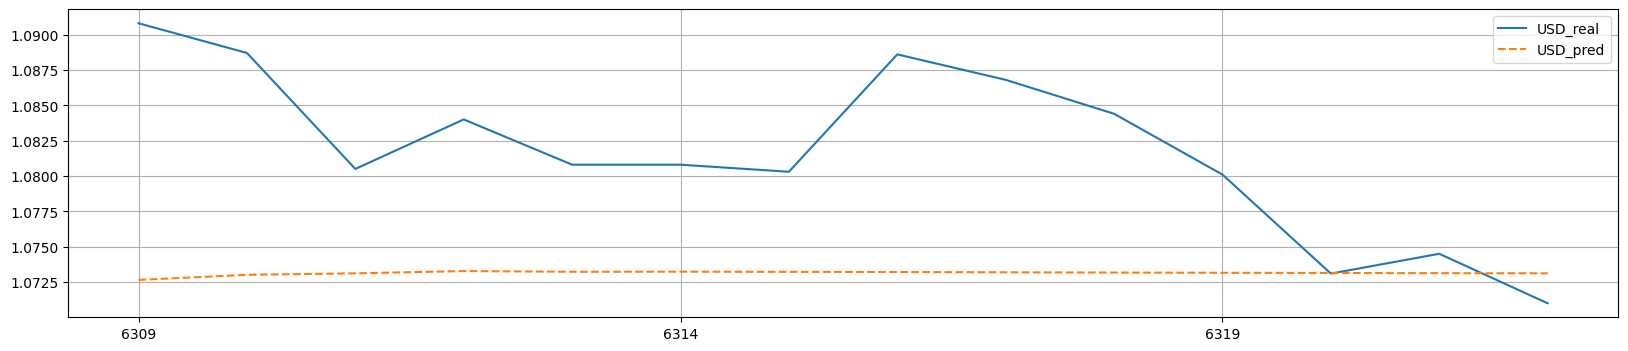

0.8264%
0.00010801784478952419


,USD_real,USD_pred
6309,1.0908,1.072653
6310,1.0887,1.073013
6311,1.0805,1.073118
6312,1.0840,1.073277
6313,1.0808,1.073228
6314,1.0808,1.073235
6315,1.0803,1.073223
6316,1.0886,1.073210
6317,1.0868,1.073191
6318,1.0844,1.073171


In [2049]:
currency = "USD"

y_true = df_daily_currencies[currency].iloc[data_end: data_end + horizon]
y_pred = df_daily_results[currency]

plt.figure(figsize=(20,4))

plt.plot(y_true)
plt.plot(y_pred, linestyle='dashed')

plt.legend([f"{currency}_real",f"{currency}_pred"])
plt.xticks(np.arange(data_end, data_end + horizon, 5))

plt.grid()
plt.show()

print(str(round(smape(y_true, y_pred) * 100, 4)) + "%")
print(np.mean((y_true - y_pred)**2))

df_daily_output = pd.DataFrame()
df_daily_output["USD_real"] = y_true
df_daily_output["USD_pred"] = y_pred
df_daily_output.to_csv('USD_daily.csv', header=True )

df_daily_output

# V-AR(p) WEEKLY

In [2050]:
df_weekly_currencies = df_daily_currencies.iloc[2:: 5].reset_index().drop(columns = "index")
df_weekly_diff = df_weekly.diff().dropna()
df_daily_currencies.iloc[2:: 5]

,USD,JPY,CZK,DKK,GBP,HUF,PLN,SEK,CHF,NOK,AUD,CAD,HKD,KRW,NZD,SGD,ZAR
2,1.1743,131.42,34.850,7.4452,0.70760,250.67,4.0065,9.3050,1.6116,8.7335,1.8820,1.7711,9.1010,1359.54,2.1890,1.9699,6.7307
7,1.1744,131.89,36.113,7.4432,0.70840,255.01,4.2033,9.1400,1.5931,8.7470,1.8620,1.8123,9.1008,1377.93,2.1744,1.9815,7.2543
12,1.1575,131.59,35.773,7.4378,0.70140,249.99,4.0847,8.9645,1.6024,8.6000,1.8064,1.7626,8.9605,1349.24,2.1499,1.9398,6.9450
17,1.1529,131.91,36.464,7.4358,0.69680,250.08,4.1588,8.8820,1.6082,8.5985,1.8313,1.7526,8.9350,1354.55,2.1594,1.9446,6.9666
22,1.1337,126.86,37.168,7.4372,0.69250,249.00,4.2014,8.9150,1.5975,8.6250,1.7609,1.7151,8.7874,1327.18,2.0566,1.9132,6.8135
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6302,1.1019,158.43,24.223,7.4512,0.86313,385.13,4.4548,11.6940,0.9618,11.1785,1.6767,1.4764,8.6127,1446.32,1.8123,1.4826,20.6870
6307,1.0900,158.88,24.078,7.4518,0.85395,384.73,4.4718,11.8666,0.9555,11.4985,1.6931,1.4718,8.5318,1458.28,1.8298,1.4793,20.7417
6312,1.0840,157.96,24.130,7.4539,0.85650,384.23,4.4768,11.9175,0.9562,11.5775,1.6838,1.4686,8.5009,1433.05,1.8266,1.4681,20.2480
6317,1.0868,158.49,24.072,7.4523,0.85718,380.13,4.4673,11.8430,0.9584,11.5800,1.6785,1.4721,8.5250,1439.56,1.8259,1.4686,20.4199


In [2051]:
print("Order 1 diff")
perform_adf_test(df_weekly_diff["USD"])

Order 1 diff
ADF Statistic: -26.393738
p-value: 0.000000


In [2052]:
horizon = 8

data_end = len(df_weekly) - horizon
data_start = 1

df_weekly_train = df_weekly_diff.iloc[data_start -1 : data_end - 1]
df_weekly_test = df_weekly_diff.iloc[data_end - 1: data_end + horizon]

In [2053]:
df_weekly_train

,USD,JPY,CZK,DKK,GBP,HUF,PLN,SEK,CHF,NOK,AUD,CAD,HKD,KRW,NZD,SGD,ZAR
1,0.0001,0.47,1.263,-0.0020,0.00080,4.34,0.1968,-0.1650,-0.0185,0.0135,-0.0200,0.0412,-0.0002,18.39,-0.0146,0.0116,0.5236
2,-0.0169,-0.30,-0.340,-0.0054,-0.00700,-5.02,-0.1186,-0.1755,0.0093,-0.1470,-0.0556,-0.0497,-0.1403,-28.69,-0.0245,-0.0417,-0.3093
3,-0.0046,0.32,0.691,-0.0020,-0.00460,0.09,0.0741,-0.0825,0.0058,-0.0015,0.0249,-0.0100,-0.0255,5.31,0.0095,0.0048,0.0216
4,-0.0192,-5.05,0.704,0.0014,-0.00430,-1.08,0.0426,0.0330,-0.0107,0.0265,-0.0704,-0.0375,-0.1476,-27.37,-0.1028,-0.0314,-0.1531
5,0.0005,3.87,0.967,-0.0025,0.00290,2.05,0.0434,0.0180,-0.0012,0.0175,-0.0040,-0.0206,0.0009,8.63,-0.0017,0.0070,0.1226
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1252,0.0082,2.88,0.126,0.0025,-0.00558,7.38,-0.0095,-0.0274,0.0010,-0.2555,-0.0137,0.0073,0.0535,-12.26,-0.0137,0.0083,-0.4032
1253,0.0166,3.19,-0.068,-0.0037,0.00560,-6.60,-0.0440,0.1018,0.0064,0.0965,0.0270,0.0048,0.1326,37.02,0.0139,0.0198,0.3323
1254,-0.0047,1.69,0.003,-0.0010,0.00285,1.47,0.0232,0.0951,-0.0042,0.1655,0.0286,0.0040,-0.0274,14.15,0.0239,0.0049,0.2070
1255,-0.0039,-1.17,0.153,0.0017,-0.01090,12.05,0.0268,0.0870,-0.0026,-0.1275,-0.0172,-0.0014,-0.0474,-18.98,-0.0405,-0.0078,0.1631


#### The Durbin–Watson statistic is a test statistic used to detect the presence of autocorrelation at lag 1 in the residuals (prediction errors) from a regression analysis. 

#### Due to the nature of our dataset, metric should be close to 2, which means no correlation.

In [2054]:
model = VAR(df_weekly_train.iloc[0:])

lag = 4
model_fitted = model.fit(lag)
#model_fitted.summary()

from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

def adjust(val, length= 6): 
    return str(val).ljust(length)

for col, val in zip(df_diff.columns, out):
    print(adjust(col), ':', round(val, 2))

USD    : 2.0
JPY    : 2.0
CZK    : 1.99
DKK    : 2.01
GBP    : 2.01
HUF    : 1.98
PLN    : 1.98
SEK    : 1.96
CHF    : 2.0
NOK    : 2.0
AUD    : 2.0
CAD    : 2.0
HKD    : 2.0
KRW    : 1.99
NZD    : 2.0
SGD    : 1.99
ZAR    : 1.99


/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


#### 

#### fit model

In [2055]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input = df_weekly_train.values[-lag_order:]
print(forecast_input)

df_weekly_train[- lag_order:]

4
[[ 1.660e-02  3.190e+00 -6.800e-02 -3.700e-03  5.600e-03 -6.600e+00
  -4.400e-02  1.018e-01  6.400e-03  9.650e-02  2.700e-02  4.800e-03
   1.326e-01  3.702e+01  1.390e-02  1.980e-02  3.323e-01]
 [-4.700e-03  1.690e+00  3.000e-03 -1.000e-03  2.850e-03  1.470e+00
   2.320e-02  9.510e-02 -4.200e-03  1.655e-01  2.860e-02  4.000e-03
  -2.740e-02  1.415e+01  2.390e-02  4.900e-03  2.070e-01]
 [-3.900e-03 -1.170e+00  1.530e-01  1.700e-03 -1.090e-02  1.205e+01
   2.680e-02  8.700e-02 -2.600e-03 -1.275e-01 -1.720e-02 -1.400e-03
  -4.740e-02 -1.898e+01 -4.050e-02 -7.800e-03  1.631e-01]
 [ 2.830e-02 -1.730e+00 -8.700e-02  3.000e-03  2.430e-03 -7.800e+00
  -4.300e-02 -3.945e-01 -1.130e-02 -3.890e-01 -9.000e-04  2.250e-02
   2.242e-01 -1.120e+00  4.800e-03  1.040e-02 -4.128e-01]]


,USD,JPY,CZK,DKK,GBP,HUF,PLN,SEK,CHF,NOK,AUD,CAD,HKD,KRW,NZD,SGD,ZAR
1253,0.0166,3.19,-0.068,-0.0037,0.00560,-6.60,-0.0440,0.1018,0.0064,0.0965,0.0270,0.0048,0.1326,37.02,0.0139,0.0198,0.3323
1254,-0.0047,1.69,0.003,-0.0010,0.00285,1.47,0.0232,0.0951,-0.0042,0.1655,0.0286,0.0040,-0.0274,14.15,0.0239,0.0049,0.2070
1255,-0.0039,-1.17,0.153,0.0017,-0.01090,12.05,0.0268,0.0870,-0.0026,-0.1275,-0.0172,-0.0014,-0.0474,-18.98,-0.0405,-0.0078,0.1631
1256,0.0283,-1.73,-0.087,0.0030,0.00243,-7.80,-0.0430,-0.3945,-0.0113,-0.3890,-0.0009,0.0225,0.2242,-1.12,0.0048,0.0104,-0.4128


####  differences prediction

In [2056]:
fc = model_fitted.forecast(y = forecast_input, steps=horizon)
df_forecast = pd.DataFrame(fc, index=df_weekly_test.index, columns=df_weekly_test.columns)
df_forecast

,USD,JPY,CZK,DKK,GBP,HUF,PLN,SEK,CHF,NOK,AUD,CAD,HKD,KRW,NZD,SGD,ZAR
1257,0.001156,0.277397,-0.009569,-0.002289,0.006194,-1.561189,0.019921,0.043454,-0.003606,0.047534,0.008018,-0.000053,0.007977,-5.404729,0.006771,0.001807,-0.067161
1258,-0.004891,-0.573812,-0.004734,-0.000797,0.001806,-0.285251,-0.004977,0.037424,-0.000415,0.064580,-0.010908,-0.004851,-0.038273,-5.016617,-0.012534,-0.007475,-0.088093
1259,-0.000278,-0.388986,-0.042601,0.000924,-0.002725,1.041108,0.017687,0.006000,-0.000711,-0.073467,-0.001645,0.000318,0.000191,0.890942,-0.001944,0.000020,0.057957
1260,0.006320,0.313247,-0.050025,0.001037,-0.001458,-0.145027,-0.013007,0.023523,0.003366,-0.018822,0.000801,-0.002413,0.046984,13.913138,0.004918,0.003487,-0.010477
1261,-0.000586,0.212553,-0.008974,-0.000358,0.001052,-0.500918,0.000752,-0.001145,0.000605,0.011016,-0.000640,0.001502,-0.003814,-0.101799,0.002308,0.000529,0.004027
1262,-0.001934,-0.126110,0.003424,-0.000256,0.000265,0.517342,0.009417,0.003717,-0.002380,0.008376,0.002672,0.000320,-0.015231,-0.966234,0.001965,-0.001298,0.029390
1263,0.002413,0.198306,-0.020154,0.000057,0.000740,0.058457,-0.004582,0.004854,0.000025,0.005925,0.002033,0.002575,0.019037,0.513070,0.000324,0.002036,0.007706
1264,0.001215,0.060980,-0.017899,-0.000042,0.001182,0.190258,0.001795,0.005566,-0.000220,0.006130,-0.000986,0.000165,0.009109,-0.675660,-0.001735,0.000265,0.027903


#### invert differences

In [2057]:
df_weekly_results = invert_transformation(df_weekly_currencies[data_end : data_end + horizon], df_forecast)        
df_weekly_results

,USD,JPY,CZK,DKK,GBP,HUF,PLN,SEK,CHF,NOK,AUD,CAD,HKD,KRW,NZD,SGD,ZAR
1257,1.072156,157.977397,24.360431,7.457611,0.865194,386.018811,4.608221,11.952954,0.952094,11.528034,1.684718,1.462447,8.404077,1426.295271,1.826071,1.463107,20.454639
1258,1.067264,157.403585,24.355697,7.456814,0.867000,385.733560,4.603245,11.990378,0.951679,11.592613,1.673809,1.457595,8.365804,1421.278654,1.813536,1.455633,20.366546
1259,1.066986,157.014599,24.313096,7.457739,0.864275,386.774669,4.620932,11.996377,0.950967,11.519146,1.672164,1.457913,8.365995,1422.169597,1.811593,1.455653,20.424503
1260,1.073306,157.327846,24.263071,7.458776,0.862817,386.629642,4.607925,12.019900,0.954334,11.500324,1.672966,1.455500,8.412979,1436.082735,1.816511,1.459140,20.414026
1261,1.072721,157.540399,24.254097,7.458418,0.863869,386.128724,4.608677,12.018756,0.954938,11.511340,1.672325,1.457002,8.409165,1435.980935,1.818819,1.459668,20.418053
1262,1.070786,157.414289,24.257521,7.458162,0.864133,386.646066,4.618094,12.022472,0.952558,11.519716,1.674997,1.457321,8.393934,1435.014701,1.820784,1.458370,20.447444
1263,1.073199,157.612595,24.237367,7.458219,0.864873,386.704523,4.613511,12.027327,0.952582,11.525642,1.677030,1.459896,8.412971,1435.527772,1.821108,1.460406,20.455149
1264,1.074414,157.673575,24.219468,7.458177,0.866055,386.894781,4.615307,12.032893,0.952363,11.531772,1.676044,1.460061,8.422080,1434.852112,1.819373,1.460670,20.483052


In [2058]:
df_weekly_currencies[data_end : data_end + horizon]

,USD,JPY,CZK,DKK,GBP,HUF,PLN,SEK,CHF,NOK,AUD,CAD,HKD,KRW,NZD,SGD,ZAR
1257,1.1197,156.35,23.961,7.4508,0.86920,379.24,4.4513,11.4795,0.9635,11.1555,1.6416,1.4716,8.7465,1423.23,1.7859,1.4807,19.9650
1258,1.1125,155.95,24.032,7.4518,0.85885,379.03,4.4265,11.4985,0.9542,11.1275,1.6383,1.4654,8.6787,1422.98,1.7797,1.4727,19.4838
1259,1.0932,156.24,24.034,7.4517,0.86468,390.85,4.4598,11.7415,0.9579,11.2765,1.6748,1.4619,8.5331,1422.79,1.7985,1.4678,20.3700
1260,1.1019,158.43,24.223,7.4512,0.86313,385.13,4.4548,11.6940,0.9618,11.1785,1.6767,1.4764,8.6127,1446.32,1.8123,1.4826,20.6870
1261,1.0900,158.88,24.078,7.4518,0.85395,384.73,4.4718,11.8666,0.9555,11.4985,1.6931,1.4718,8.5318,1458.28,1.8298,1.4793,20.7417
1262,1.0840,157.96,24.130,7.4539,0.85650,384.23,4.4768,11.9175,0.9562,11.5775,1.6838,1.4686,8.5009,1433.05,1.8266,1.4681,20.2480
1263,1.0868,158.49,24.072,7.4523,0.85718,380.13,4.4673,11.8430,0.9584,11.5800,1.6785,1.4721,8.5250,1439.56,1.8259,1.4686,20.4199
1264,1.0710,157.70,24.370,7.4599,0.85900,387.58,4.5883,11.9095,0.9557,11.4805,1.6767,1.4625,8.3961,1431.70,1.8193,1.4613,20.5218


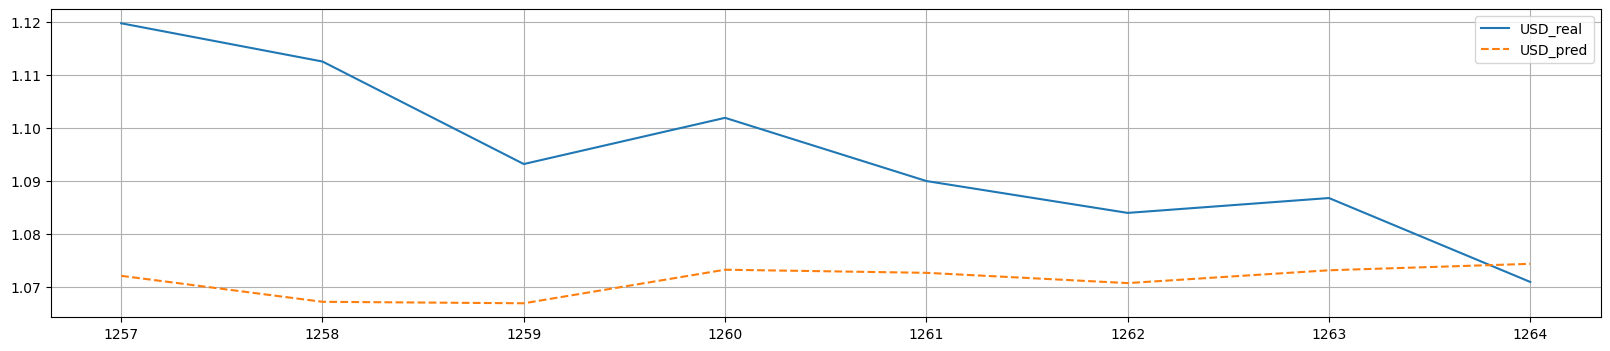

2.2434%
0.0008101667141044901


,USD_real,USD_pred
1257,1.1197,1.072156
1258,1.1125,1.067264
1259,1.0932,1.066986
1260,1.1019,1.073306
1261,1.0900,1.072721
1262,1.0840,1.070786
1263,1.0868,1.073199
1264,1.0710,1.074414


In [2059]:
currency = "USD"

y_true = df_weekly_currencies[currency].iloc[data_end: data_end + horizon]
y_pred = df_weekly_results[currency]

plt.figure(figsize=(20,4))

plt.plot(y_true)
plt.plot(y_pred, linestyle='dashed')

plt.legend([f"{currency}_real",f"{currency}_pred"])
plt.xticks(np.arange(data_end, data_end + horizon, 1))

plt.grid()
plt.show()

print(str(round(smape(y_true, y_pred) * 100, 4)) + "%")
print(np.mean((y_true - y_pred)**2))

df_weekly_output = pd.DataFrame()
df_weekly_output["USD_real"] = y_true
df_weekly_output["USD_pred"] = y_pred
df_weekly_output.to_csv('USD_weekly.csv', header=True)

df_weekly_output